# Markov Chains

In [1]:
%matplotlib inline
import numpy as np

In [2]:
%load_ext dotmagic

### Markov Chain

Suppose we have the following transition table:

|             | Raleigh | Chapel Hill | Durham |
|:------------|:--------|:------------|:-------|
| Raleigh     | 0.9     | 0.05        | 0.05   |
| Chapel Hill | 0.1     | 0.8         | 0.1    |
| Durham      | 0.04    | 0.01        | 0.95   |

This says that a resident of Raleigh this year has a 90% chance of stying in Raleigh and a 5% chance of relocating to Chapel Hill or Durham the following year. Note that the probabilities only depend on the current year. The transitions between states (Raleigh, Chapel Hill and Durham) are then said to be modeled by a Markov chain. 

If Raleigh, Chapel Hill and Durham each started with 300,000 residents, what is the long run distribution assuming no immigration or emigration?

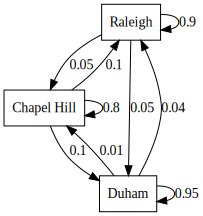

In [3]:
%%dot

digraph g {
    node [shape=box]
    R [label="Raleigh"]
    C [label="Chapel Hill"]
    D [label="Duham"]
    R -> R [label=0.9]
    R -> C [label=0.05]
    R -> D [label=0.05]
    C -> R [label=0.1]
    C -> C [label=0.8]
    C -> D [label=0.1]
    D -> R [label=0.04]
    D -> C [label=0.01]
    D -> D [label=0.95]
}

In [4]:
A = np.array([
    [0.9, 0.05, 0.05],
    [0.1, 0.8, 0.1],
    [0.04, 0.01, 0.95]
])

In [5]:
x = np.array([300000, 300000, 300000]).reshape(-1,1)

#### After one year

In [6]:
x.T @ A

array([[312000., 258000., 330000.]])

#### After 2 years

In [7]:
x.T @ A @ A

array([[319800., 225300., 354900.]])

#### Brute force solution

In [8]:
n = 100
x.T @ np.linalg.matrix_power(A, n)

array([[300000.50469469, 100000.21203929, 499999.28326602]])

#### Eigenvector solution

At steady state, we have

$$
p.T A = p.T
$$

Taking the transpose on both sides, we see that

$$
A^Tp = p
$$

suggesting that the steady state probability vector is the normalized eigenvector of $A^T$ with $\lambda = 1$.

In [9]:
E, V = np.linalg.eig(A.T)

In [10]:
E

array([0.76479203, 0.88520797, 1.        ])

In [11]:
p = V[:, 2:] / V[:, 2:].sum()
p

array([[0.33333333],
       [0.11111111],
       [0.55555556]])

In [12]:
p * x.sum()

array([[300000.],
       [100000.],
       [500000.]])

#### Linear system solution

We cannot solve $A^Tp - p= \mathbb{0}$ directly because $A^T - I$ does not have full rank (since the last column of $A$ is fixed given the other columns).

We need to add the constraint $\sum{p} = 1$ and then we can solve the linear system to find $p$. 

$$
\begin{bmatrix}
(A^T - I) \\
\mathbb{1}^T 
\end{bmatrix} p = \begin{bmatrix}
\mathbb{0} \\
1 \end{bmatrix}
$$

In [13]:
np.linalg.matrix_rank(A.T - np.eye(3))

2

In [14]:
M = np.r_[A.T - np.eye(3), [np.ones(3)]]
b = np.r_[np.zeros(3), 1].reshape(-1,1)

In [15]:
M

array([[-0.1 ,  0.1 ,  0.04],
       [ 0.05, -0.2 ,  0.01],
       [ 0.05,  0.1 , -0.05],
       [ 1.  ,  1.  ,  1.  ]])

In [16]:
b

array([[0.],
       [0.],
       [0.],
       [1.]])

In [17]:
x, res, rank, s = np.linalg.lstsq(M, b, rcond=None)

In [18]:
x

array([[0.33333333],
       [0.11111111],
       [0.55555556]])

### Markov chain averages

We can also consider the perspective of a single individual in terms of the frequencies of places visited.

The individual starts from one of the 3 places (Raleigh, Chapel Hill or Durham) and moves from place to place according to the probabilities in $A$ over a long time. In the long run, the average frequency of visits to a place is the steady state probability of visiting that place.

This suggests that we can estimate the equilibrium or steady state distribution by using the long-run averages, which we'll revisit when we look at Markov chain Monte Carlo (MCMC). Note that the initial averages depend on the starting conditions, so it is common practice to discard some number of the initial iterations (burn-in).

In [19]:
P = np.cumsum(A).reshape(A.shape) - np.array([0,1,2]).reshape(-1,1)
P

array([[0.9 , 0.95, 1.  ],
       [0.1 , 0.9 , 1.  ],
       [0.04, 0.05, 1.  ]])

In [20]:
n = int(1e6)
xs = np.zeros(n+1).astype('int')
xs[0] = np.random.choice([0,1,2])

for t in range(n):
    r = np.random.rand()
    xs[t+1] = np.argmax(r < P[xs[t]])

In [21]:
np.mean(xs==0), np.mean(xs==1), np.mean(xs==2)

(0.33457266542733455, 0.11134688865311135, 0.5540804459195541)